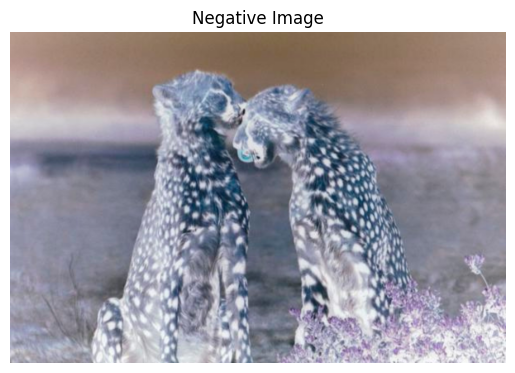

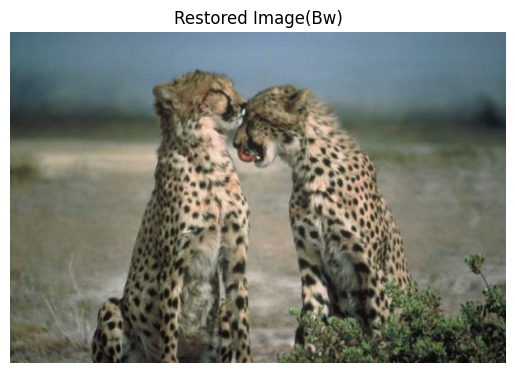

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from memory_profiler import memory_usage


def matmul(A, B):
    result = []
    for i in range(len(A)):
        row = []
        for j in range(len(B[0])):
            row.append(sum(A[i][k] * B[k][j] for k in range(len(A[0]))))
        result.append(row)
    return result

def transpose(A):
    return [list(row) for row in zip(*A)]

def inverse_2x2(A):
    if len(A) == 1 and len(A[0]) == 1:
        if abs(A[0][0]) < 1e-10:
            raise ValueError("Matrix is singular")
        return [[1 / A[0][0]]]
    
    if len(A) != 2 or len(A[0]) != 2:
        raise ValueError("inverse_2x2 called with non-2x2 matrix")
    
    det = A[0][0]*A[1][1] - A[0][1]*A[1][0]
    if abs(det) < 1e-10:
        raise ValueError("Matrix is singular")
    
    return [[A[1][1]/det, -A[0][1]/det],
            [-A[1][0]/det, A[0][0]/det]]

def is_singular(A):
    A_np = np.array(A)
    det = np.linalg.det(A_np)
    return abs(det) < 1e-10

def inverse_matrix(A):
    if is_singular(A):
        raise ValueError("Matrix is singular and cannot be inverted")
    
    n = len(A)
    if n <= 2:
        return inverse_2x2(A)

    A_np = np.array(A, dtype=float)
    A_inv_np = np.linalg.inv(A_np)
    
    A_inv = A_inv_np.tolist()
    return A_inv


def restore_image(negative_img, T_inv):
    img = negative_img.astype(np.float32)
    h, w, _ = img.shape
    ones = np.ones((h, w, 1), dtype=np.float32)
    img_homogeneous = np.concatenate((img, ones), axis=2)
    img_reshaped = img_homogeneous.reshape(-1, 4).T
    restored = np.matmul(T_inv, img_reshaped)
    restored = restored[:3, :].T.reshape(h, w, 3)
    restored = np.clip(restored, 0, 255).astype(np.uint8)
    return restored

def show_image(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


if __name__ == '__main__':
    T = [
        [-1, 0, 0, 255],
        [0, -1, 0, 255],
        [0, 0, -1, 255],
        [0, 0, 0, 1]
    ]

    def wrapper(func, *args):
        return func(*args)

    T_inv = inverse_matrix(T)
    T_inv = np.array(T_inv)

    input_path = 'negative.png'
    negative_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

    if negative_img is None:
        print("Error: Could not load image.")
    else:
        if negative_img.shape[2] == 4:
            negative_img = negative_img[:, :, :3]

        show_image(negative_img, "Negative Image")

        restored_img = restore_image(negative_img, T_inv)

        show_image(restored_img, "Restored Image(Bw)")

        output_path = 'restored_image_custom_inverse.png'
        cv2.imwrite(output_path, restored_img)
